In [1]:
import sys
import os
import numpy as np
import pandas as pd         
import xarray as xr         
import matplotlib.pyplot as plt  
import stackstac
from pystac_client import Client as StacClient
from dask.distributed import Client, LocalCluster
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

In [2]:
cluster = LocalCluster(
    n_workers=4,             
    threads_per_worker=1,    
    memory_limit="6GB"       
)
client = Client(cluster)
cluster    


LocalCluster(c254336a, 'tcp://127.0.0.1:45889', workers=4, threads=4, memory=22.35 GiB)

In [3]:
sys.path.append(os.path.abspath("../utils"))

# Import plotting functions from spatial utilities
from spatial_utils import plot_wqi_mean_maps, plot_wqi_std_maps
from stack_loader import load_wqi_stack

In [4]:
TAMPA_BAY = (-82.7167, 27.5833, -82.3833, 28.0333)

start_date = "2019-12-01"
end_date = "2024-12-31"

In [5]:
# Load pixel-level Sentinel-2 stack
print("Loading pixel-level Sentinel-2 stack...")
stack = load_wqi_stack(
    bbox=TAMPA_BAY,
    start_date=start_date,
    end_date=end_date,
    epsg=32617,
    max_items=100,
    filter_clouds=True
)

Loading pixel-level Sentinel-2 stack...
Stack loaded with shape: (26, 5, 4912, 3271)


/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [6]:
def normalized_diff(a, b):
    """Compute normalized difference (a - b) / (a + b) with small epsilon for safety."""
    return (a - b) / (a + b + 1e-10)

bands = stack.sel(band=["green", "red", "nir", "rededge1"])

wqi_ds = xr.Dataset(
    {
        "NDWI": normalized_diff(bands.sel(band="green"),    bands.sel(band="nir")),
        "NDTI": normalized_diff(bands.sel(band="red"),      bands.sel(band="green")),
        "NDCI": normalized_diff(bands.sel(band="rededge1"), bands.sel(band="red")),
    }
)

## Plotting for just NDWI mean

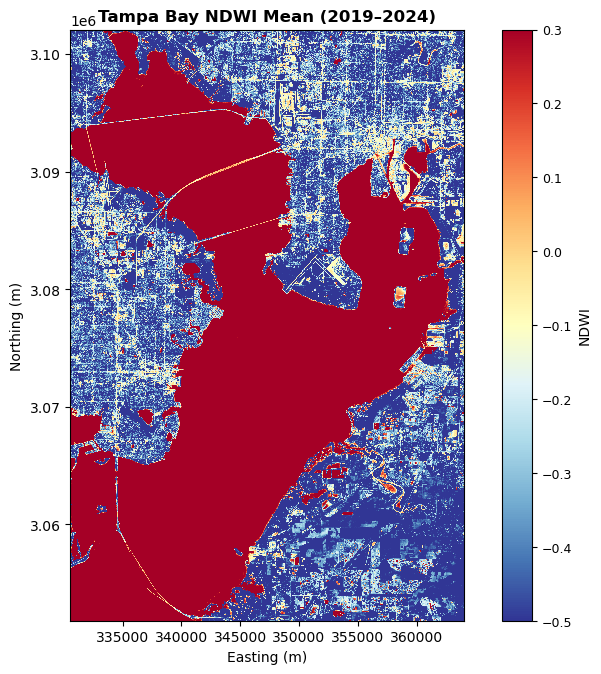

In [7]:
ndwi_mean = wqi_ds["NDWI"].mean("time").compute()

fig, ax = plt.subplots(figsize=(8, 7))

img = ndwi_mean.plot(
    ax=ax,
    cmap="RdYlBu_r",
    vmin=-0.5,
    vmax=0.3,
    add_colorbar=False,
)

ax.set_title("Tampa Bay NDWI Mean (2019–2024)", fontweight="bold")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect("equal")

cbar = plt.colorbar(img, ax=ax, label="NDWI")
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


## Map Showing Mean of Indices

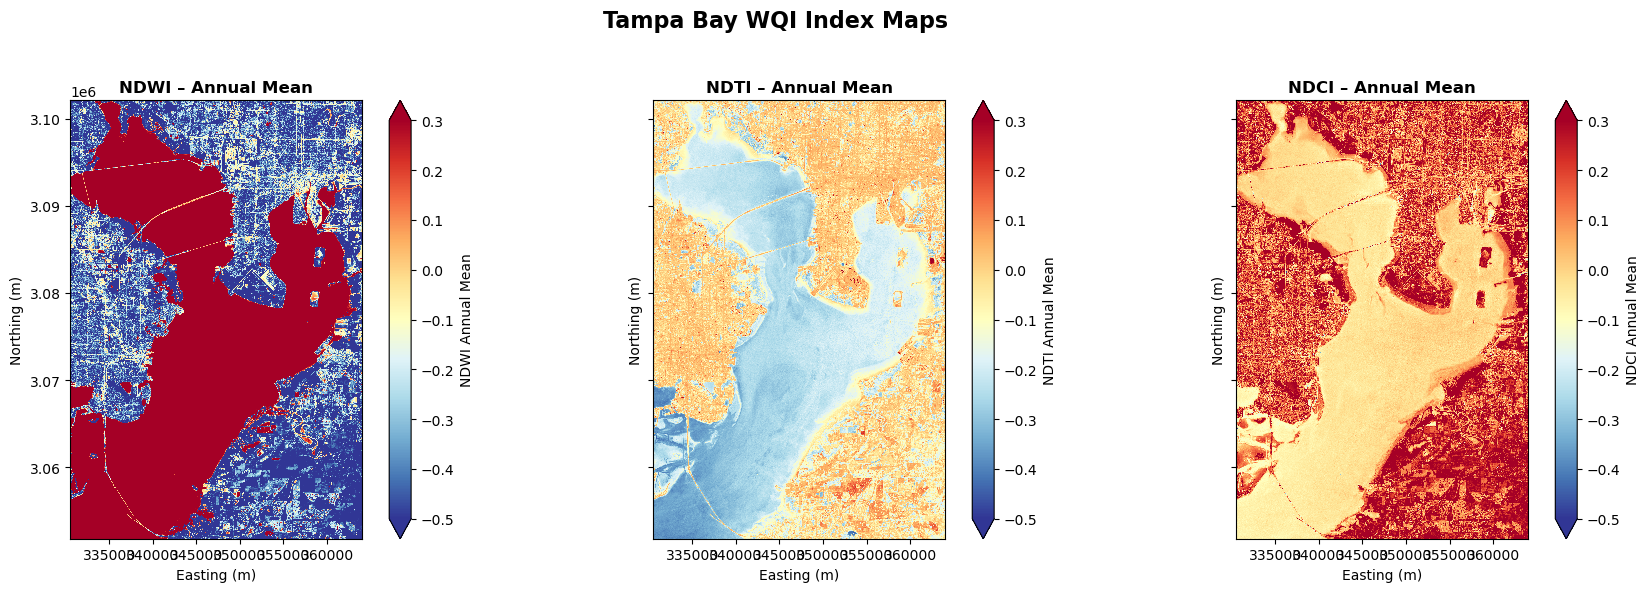

In [8]:
# Plotting indices standard deviation
plot_wqi_mean_maps(
    stack,
    title="Tampa Bay WQI Index Maps"
)

## Map Showing Standard Deviation of Indices

2025-12-18 09:21:23,616 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 4.60 GiB -- Worker memory limit: 5.59 GiB
2025-12-18 09:21:23,804 - distributed.worker.memory - WARNING - Worker is at 65% memory usage. Resuming worker. Process memory: 3.65 GiB -- Worker memory limit: 5.59 GiB
2025-12-18 09:23:20,086 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 4.81 GiB -- Worker memory limit: 5.59 GiB
2025-12-18 09:23:20,346 - distributed.worker.memory - WARNING - Worker is at 70% memory usage. Resuming worker. Process memory: 3.94 GiB -- Worker memory limit: 5.59 GiB
2025-12-18 09:24:18,436 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.54 GiB -- Worker memory limit: 5.59 GiB
2025-12-18 09:24:18,532 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 4.39 GiB -- Worker mem

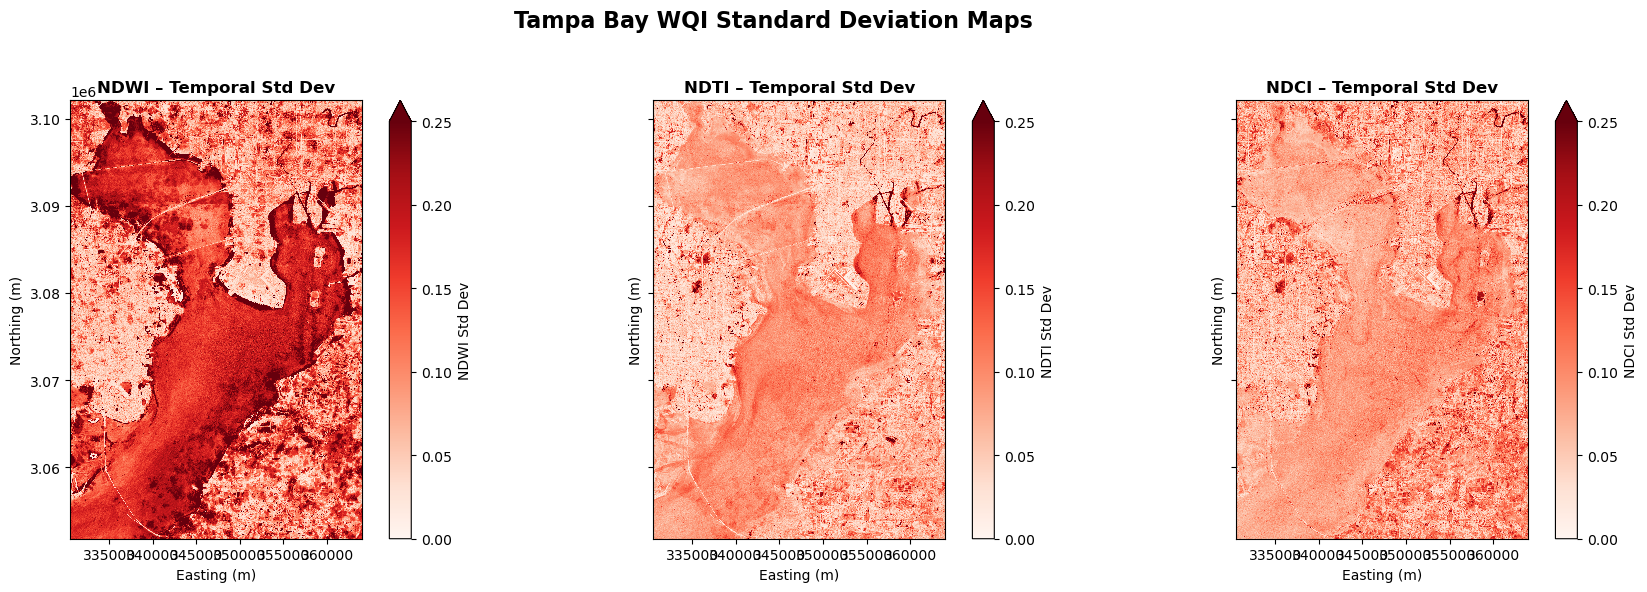

In [9]:
plot_wqi_std_maps(
    stack,
    title="Tampa Bay WQI Standard Deviation Maps"
)

## Composite Risk Map OF Tampa Bay

In [ ]:
# Computing mean time indices from wqi_ds
ndwi_mean = wqi_ds["NDWI"].mean("time")
ndti_mean = wqi_ds["NDTI"].mean("time")
ndci_mean = wqi_ds["NDCI"].mean("time")

# Normalizing indices to 0–1 (min–max)
def minmax_norm(da):
    return (da - da.min()) / (da.max() - da.min() + 1e-10)

ndwi_n = minmax_norm(ndwi_mean)
ndti_n = minmax_norm(ndti_mean)
ndci_n = minmax_norm(ndci_mean)

# Applying equal weights
#    (1 - ndwi_n) inverts NDWI so low NDWI => high risk
risk = ((1 - ndwi_n) + ndti_n + ndci_n) / 3.0

# Classify into 0=low, 1=medium, 2=high with np.digitize
risk_class = xr.apply_ufunc(
    lambda x: np.digitize(x, bins=[0.33, 0.66]),
    risk,
    dask="parallelized",
    output_dtypes=[int],
)

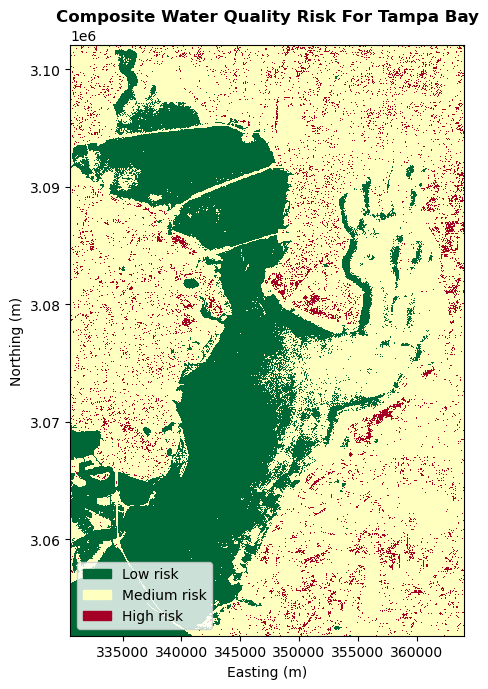

In [17]:
fig, ax = plt.subplots(figsize=(8, 7))

cmap = plt.get_cmap("RdYlGn_r", 3)

img = risk_class.plot(
    ax=ax,
    cmap=cmap,
    vmin=-0.5,
    vmax=2.5,
    add_colorbar=False,
)

ax.set_title("Composite Water Quality Risk Tampa Bay", fontweight="bold")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_aspect("equal")

# Legend using Patch (0=low, 1=medium, 2=high)
legend_handles = [
    Patch(color=cmap(0), label="Low risk"),
    Patch(color=cmap(1), label="Medium risk"),
    Patch(color=cmap(2), label="High risk"),
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True)

plt.tight_layout()
plt.show()
